In [8]:
"""
사전 준비
1. 필요 패키지 설치
"""
%pip install pycryptodome
%pip install image
%pip install pillow

Note: you may need to restart the kernel to use updated packages.
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 85.9 MB/s eta 0:00:00:00:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.0/74.0 kB 18.5 MB/s eta 0:00:00
  Created wheel for image: filename=image-1.5.33-py2.py3-none-any.whl size=19483 sha256=5e201ebe4fab9186f5bb6f6e793a90a01cd17b49ad6ec7ac8154613d01c823be
  Stored in directory: /home/notebook/.cache/pip/wheels/b0/c1/54/cf02e5fc0b07de6ad8b48fd74ccc5d3d537f19e322806a6de9
Successfully built image
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [18]:
# Inference용 class 정의
import datetime as dt
import base64
import json

import requests
from Crypto.PublicKey import RSA
from Crypto.Cipher import PKCS1_OAEP
from Crypto.Hash import SHA256, SHA1
from Crypto.Signature import pss
import numpy as np
from PIL import Image as PIL_image

class AIRuntime:
    PEM_FORMAT = "-----BEGIN PUBLIC KEY-----\n{0}\n-----END PUBLIC KEY-----\n"

    def __init__(self, access_key_id, access_key, model_id):
        self._baseEndpoint = "https://aiip.skcc.com"
        self._tokenValidMinutes = 10
        self._access_key_id = access_key_id
        self._access_key = access_key
        self._model_Id = model_id
        self._rsa_key = self.extract_rsa_key()
        self._token = self.get_token()

    def extract_rsa_key(self):
        pem_data = self.PEM_FORMAT.format(self._access_key)
        rsa_key = RSA.importKey(pem_data)
        return rsa_key

    def get_endpoint(self):
        return self._baseEndpoint + "/api/runtime/ifservice/predict"

    def get_token(self):
        _msg = str(int(dt.datetime.now().timestamp() - 1))
        _cipher = PKCS1_OAEP.new(key=self._rsa_key, hashAlgo=SHA256, mgfunc=lambda x, y: pss.MGF1(x, y, SHA1))
        _enc_str = _cipher.encrypt(str.encode(_msg))
        _b64_encoded_str = base64.b64encode(_enc_str)

        _headers = dict()
        _headers["Content-Type"] = "application/json"
        _payload = dict()
        _payload["keyId"] = self._access_key_id
        _payload["encMessage"] = bytes.decode(_b64_encoded_str)
        _payload["duration"] = self._tokenValidMinutes
        url = "https://aiip.skcc.com/api/common/backend/admin/api/keyauth"
        res = requests.post(url, headers=_headers, json=_payload)
        if res.status_code == 200:
            token = res.content.decode("utf-8")
            return token
        else:
            print("Error: ", str(res.content.decode("utf-8")))

    def predict(self, model_id=None, img_path=None):
        # 예측 테스트
        #print("# 2. 예측 실행")
        img = PIL_image.open(img_path)
        imgArray = np.array(img)
        imgArray = imgArray.tolist()

        payload = {"instance_type": "numpy", "instances":[imgArray]}
        json_data = json.loads(ai_runtime.get_token())
        token = json_data['result']

        return self.predict_exec(model_id, payload, token)

    def predict_exec(self, model_id, data, token):
        _headers = dict()
        _headers["Content-Type"] = "application/json"
        _headers["Api-Auth-Token"] = token
        _payload = data
        _url = self.get_endpoint() + "/" + model_id
        _res = requests.post(_url, headers=_headers, json=_payload)

        if _res.status_code == 200:
            _result = str(_res.content.decode("utf-8"))
            return _result
        else:
            print("Error: ", str(_res.content.decode("utf-8")))

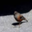

{"predictions": ["Deer"], "model_version": "7"}


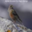

{"predictions": ["Bird"], "model_version": "7"}


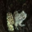

{"predictions": ["Deer"], "model_version": "7"}


In [19]:
"""
예측 데이터 준비 및 예측 API 호출

# 참조 : https://aiip-dev.github.io/docs/AI%20Runtime/%EB%AA%A8%EB%8D%B8%20%EB%A0%88%EC%A7%80%EC%8A%A4%ED%8A%B8%EB%A6%AC%20%EB%AA%A9%EB%A1%9D/%EB%AA%A8%EB%8D%B8%20%EC%83%81%EC%84%B8/%EC%99%B8%EB%B6%80%20%EB%AA%A8%EB%8D%B8%20%EC%98%88%EC%B8%A1%20%EC%9A%94%EC%B2%AD
"""
import yaml

with open('config.yaml') as f:
    conf = yaml.safe_load(f)

apiKeyId = conf['apiKeyId']
apiKey = conf['apiKey']
modelId = conf['modelId']
infer_count = conf['infer_count']

import os
import random
from IPython.display import Image, display

path_dir = './dataset/sample'
test_images = os.listdir(path_dir)
random.shuffle(test_images)

ai_runtime: AIRuntime = AIRuntime(access_key_id=apiKeyId, access_key=apiKey, model_id=modelId)

for img in test_images[:infer_count]:
    img_path = f"{path_dir}/{img}"
    display(Image(img_path, width=50, height=50))
    predict_result = ai_runtime.predict(modelId, img_path)
    print(predict_result)